# 1 - Linear Classification and Nearest Neighbor Classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
random.seed(10)
plt.style.use('ggplot')
n = 20
Nc = [2000, 2000]
Cls  = ["-","+"]

def createData(Ndataset, Pdist, setBounds=[0, 0.6, 0.8, 1]):
    Sets = ["Train", "Valid", "Test"]
    Ndist = len(Pdist)
    Class = [{"X": np.empty((Nc[c-1], n)),
              "Y": np.full((Nc[c-1], 1), c-1),
              "N": Nc[c-1],
              "pi": Nc[c-1]/sum(Nc),
              "Mean": [np.genfromtxt(f"hwk2_datasets\DS{Ndataset}_c{c}_m{i}.txt",
                                     delimiter=",")[:-1]   .reshape((1, n)) for i in range(1, Ndist+1)],
              "Cov":  [np.genfromtxt(f"hwk2_datasets\DS{Ndataset}_Cov{i}.txt",
                                     delimiter=",")[:, :-1].reshape((n, n)) for i in range(1, Ndist+1)],
              "randOrder": []} for c in [1, 2]]

    for c in Class:
        for i in range(c["N"]):
            dist = np.searchsorted(Pdist, random.rand())
            c["X"][i, :] = random.multivariate_normal(
                c["Mean"][dist][0], c["Cov"][dist])
        c["randOrder"] = random.permutation(c["N"])

    data = dict((s, {"X": np.array([]), "Y": np.array([]), "N": []})
                for s in Sets)
    for i in range(len(Sets)):
        sample0 = Class[0]["randOrder"][range(
            int(setBounds[i]*c["N"]), int(setBounds[i+1]*c["N"]))]
        sample1 = Class[1]["randOrder"][range(
            int(setBounds[i]*c["N"]), int(setBounds[i+1]*c["N"]))]
        data[Sets[i]]["X"] = np.append(Class[0]["X"][sample0], Class[1]["X"][sample1], axis=0).reshape(
            (len(sample0) + len(sample1), n))
        data[Sets[i]]["Y"] = np.append(Class[0]["Y"][sample0], Class[1]["Y"][sample1]).reshape(
            (len(sample0) + len(sample1), 1))
        data[Sets[i]]["N"] = len(data[Sets[i]]["Y"])
    
    printModel(data)
    return data

def printModel(d):
    print("A Random member of each datasets is as follow: \n")
    print(" "*6 + str().join([f"  x{i:<2}  "   for i in range(1,n+1)]) + "Y")
    for Set in d:
        Rand = random.randint(d[Set]["N"])
        X = d[Set]["X"][Rand]
        Y = Cls[d[Set]["Y"][Rand][0]]
        print(f"{Set:5}" + str().join([f" {X[j]:+.2f} " for j in range(n)]) + f" {Y}")


def defClass(d):

    Class = [{"List": np.array([False] * d["N"]), "N":0,
              "pi":0, "mu": 0, "cov": 0} for i in range(2)]
    for i in range(d["N"]):
        Class[d["Y"][i][0]]["List"][i] = True

    for c in Class:
        c["N"] = sum(c["List"])
        c["pi"] = c["N"]/d["N"]
        c["mu"] = np.mean(d["X"][c["List"]], axis=0).reshape((1, n))
        c["cov"] = np.cov(d["X"][c["List"]].T)
    return Class


def Parameters(C):
    Sigma = (C[0]["cov"]*C[0]["N"] + C[1]["cov"]*C[1]["N"])/(C[0]["N"]+C[1]["N"])
    sigInv = np.linalg.inv(Sigma)
    W = np.append(1/2 * (np.matmul(np.matmul(C[1]["mu"], sigInv), C[1]["mu"].T) -
                         np.matmul(np.matmul(C[0]["mu"], sigInv), C[0]["mu"].T)) +
                  np.log(C[0]["pi"]/C[1]["pi"]),
                  np.matmul(sigInv, C[0]["mu"].T - C[1]["mu"].T)).reshape((1, n+1))[0]
    return W, Sigma

def printW_mu(W, C, S):
    mu0 = C[0]["mu"][0]
    mu1 = C[1]["mu"][0]
    pi = [C[0]["pi"] , C[1]["pi"]]
    print(" "*3  + str().join([f" {i:6} "   for i in range(n+1)]))
    print(" "*3 + "W :"              + str().join([f" {W[i]  :+6.2f} " for i in range(n+1)]))
    print(" "*3 + "\u03BC₁:" + " "*8 + str().join([f" {mu0[i]:+6.3f} " for i in range(n)]))
    print(" "*3 + "\u03BC₂:" + " "*8 + str().join([f" {mu1[i]:+6.3f} " for i in range(n)]))
    print(str().join([f"\n\u03C0₁ = {pi[i]}" for i in range(2)] ))
    print("\n Sigma :")
    print(np.array_str(S, precision=2, max_line_width=130))
    

def Probability(W, d):
    return 1/(1+np.exp(-np.matmul(W[1:], d["X"].T)-W[0])).reshape((d["N"], 1))


def Accuracy(d, C):
    correct = np.sum(d["Y"].reshape((d["N"], 1)) == C.reshape((d["N"], 1)))
    return correct/d["N"]

### 1- Create Data

In [3]:
DS1 = createData(Ndataset=1, Pdist = [1], setBounds = [0,0.6,0.8,1])
# DS1["Train"]["X"]
# DS1["Valid"]["X"]
# DS1["Test" ]["X"]
# DS1["Test" ]["Y"]

A Random member of each datasets is as follow: 

        x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x11    x12    x13    x14    x15    x16    x17    x18    x19    x20  Y
Train +1.29  +0.64  +2.43  +2.51  +3.39  +1.45  +1.87  +1.41  +0.50  +2.82  +2.88  -0.77  +0.41  +3.54  +4.12  +3.07  -0.15  +1.76  +1.34  +3.16  +
Valid +2.64  +4.02  +4.65  +3.97  +3.83  +3.45  +2.63  +1.17  +3.40  +1.68  +3.20  +2.22  +1.48  +3.14  +3.23  +1.36  +5.10  +1.96  +1.83  +1.70  +
Test  +4.54  +3.08  +4.49  +4.13  +3.25  +5.26  +2.27  +2.48  +3.59  +5.42  +2.94  +2.56  +5.60  +1.36  +2.84  +3.57  +2.97  +3.51  +0.30  +5.30  +


### 2- GDA

In [4]:
Class    = defClass(DS1["Train"])
W, Sigma = Parameters(Class)
P = Probability(W, DS1["Test"])
Pred = (P<0.5)
Accu = Accuracy(DS1["Test"],Pred)

print(f"\nThe accuracy for the test set is: {Accu*100:.2f}%\n")
printW_mu(W, Class, Sigma)


The accuracy for the test set is: 94.38%

         0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20 
   W : +26.79  +13.97   -8.29   -5.69   -3.22   -9.48   -3.99  +16.56  -23.30  -28.46   +8.90  -12.73  -11.90  +15.14  +12.72   -5.37  +12.58  +28.67   -6.63   -0.86   -4.80 
   μ₁:         +1.198  +1.199  +1.113  +1.214  +1.160  +1.163  +1.187  +1.245  +1.169  +1.177  +1.228  +1.233  +1.211  +1.227  +1.214  +1.200  +1.150  +1.197  +1.249  +1.275 
   μ₂:         +2.019  +2.008  +2.001  +2.028  +2.024  +1.973  +2.057  +1.976  +2.038  +1.996  +2.039  +2.001  +2.040  +2.018  +2.065  +2.016  +1.986  +1.968  +2.042  +2.079 

π₁ = 0.5
π₁ = 0.5

 Sigma :
[[7.61 5.39 5.8  4.97 5.58 5.86 4.57 5.24 4.81 5.02 3.79 5.06 6.77 5.85 5.83 5.8  5.58 5.42 5.51 5.8 ]
 [5.39 6.95 5.17 4.25 5.35 5.49 4.32 3.91 4.04 5.03 3.32 4.56 5.81 5.02 5.28 5.11 5.54 5.   5.39 5.32]
 [5.8  5.17 6.89 4.65 5.4

### 3- kNN

In [5]:
from tqdm import tqdm
def kNNfinder(d1, d2):
    NN = np.empty((d2["N"],d1["N"]),dtype=int)
    for i,x in enumerate(tqdm(d2["X"],leave=False)):
        distances = np.sum(np.power(d1["X"]-x,2),axis=1)
        NN[i] = d1["Y"][np.argsort( distances )].reshape((1,d1["N"]))
    print("kNN is ready!")
    return NN


def TrainK(d, kNN, kVec):

    Sum = np.sum(kNN[:,:kVec[0]],axis=1)
    Accu = []
    for k in kVec:
        C = Sum>0.5*k
        Accu.append((k, Accuracy(d, C)))
        Sum = Sum + kNN[:,k]
    return Accu

def plotAccuracy(Accu):
    plt.plot(*zip(*Accu), label="Accuracy")
    plt.title("Accuracy w.r.t number of neighbors")
    plt.axis()
    plt.xlabel("k")
    plt.ylabel("Accuracy (%)")

def printResult(Accu, nk):
    if nk>20:
        Show = np.sort(random.permutation(nk)[:20])
        print("Randomly chosen result:")
    else:
        Show = range(nk)
        print(f"Result for k 1 to {nk}:")

    (K,AccuM)=max(Accu, key=lambda x:x[1])
    print("       k :"+str().join([f"  {k:3}   "  for k in [Accu[i][0] for i in Show]]))
    print("Accuracy :"+str().join([f" {a*100:2.2f}% " for a in [Accu[i][1] for i in Show]]) +"\n")
    print(f"Best Accuracy in Validation Set is {AccuM*100:.2f}% w.r.t. {K} Neighbors.")
    


### 3-a

kNN is ready!
Randomly chosen result:
       k :   31      63     127     225     228     265     344     462     531     757     840     850     975     980     989     1119     1146     1185     1290     1328   
Accuracy : 56.12%  55.88%  58.13%  57.88%  57.75%  57.75%  57.63%  57.88%  58.13%  57.38%  56.12%  56.50%  56.62%  56.50%  56.62%  56.62%  56.38%  56.50%  56.12%  55.75% 

Best Accuracy in Validation Set is 59.38% w.r.t. 110 Neighbors.


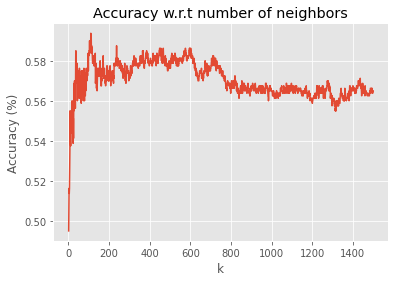

In [6]:
nk = 1500
kNN = kNNfinder(DS1["Train"], DS1["Valid"])
Accu = TrainK(DS1["Valid"], kNN, range(1,nk+1))
(K,AccuM)=max(Accu, key=lambda x:x[1])
plotAccuracy(Accu)
printResult(Accu, nk)

### 3-b

In [7]:
kNN = kNNfinder(DS1["Train"], DS1["Test"])
Accu = TrainK(DS1["Test"], kNN, [K])
(K,AccuM)=max(Accu, key=lambda x:x[1])
print(f"Accuracy for Test Set is {AccuM*100:.2f}% w.r.t. {K} Neighbors.")

kNN is ready!
Accuracy for Test Set is 56.12% w.r.t. 110 Neighbors.


### 4. Multivariate Gaussian Distribution - Create Data

In [8]:
DS2 = createData(Ndataset=2, Pdist = np.cumsum([0.1,0.42,0.48]), setBounds = [0,0.6,0.8,1])
# DS2["Train"]["X"]
# DS2["Valid"]["X"]
# DS2["Test" ]["X"]
# DS2["Test" ]["Y"]

A Random member of each datasets is as follow: 

        x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x11    x12    x13    x14    x15    x16    x17    x18    x19    x20  Y
Train +5.11  +5.74  +4.03  +5.41  +5.16  +6.14  +7.38  +4.51  +4.82  +5.87  +2.70  +2.64  +4.36  +6.65  +4.50  +6.38  +3.51  +5.10  +5.05  +6.51  -
Valid +1.52  +2.22  +3.46  +1.74  +3.00  +2.40  +3.10  +0.75  +2.80  +4.09  +3.69  +4.66  +3.99  +2.05  +3.79  +3.15  +0.91  +1.40  +4.62  +2.10  -
Test  -1.78  -1.85  -3.10  -1.43  -1.77  -0.83  -1.41  -2.27  -1.31  -1.38  -1.71  +0.94  -2.27  -1.48  +0.32  -1.82  -0.02  -1.97  -1.70  -0.14  -


### 5.1 GDA 

In [9]:
Class = defClass(DS2["Train"])
W, Sigma = Parameters(Class)
P = Probability(W, DS2["Test"])
Pred = (P<0.5)
Accu = Accuracy(DS2["Test"],Pred)

print(f"\n The accuracy is: {Accu*100}%\n")
printW_mu(W, Class, Sigma)


 The accuracy is: 51.24999999999999%

         0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20 
   W :  +0.02   -0.00   -0.00   -0.05   -0.01   -0.03   -0.00   -0.04   -0.07   +0.02   -0.00   -0.01   -0.04   -0.02   +0.01   +0.02   +0.11   -0.03   +0.09   -0.00   +0.04 
   μ₁:         +1.071  +1.005  +0.933  +0.912  +1.014  +0.997  +0.920  +1.020  +0.974  +0.981  +0.995  +0.951  +0.990  +1.007  +1.018  +1.057  +0.997  +1.064  +0.969  +1.071 
   μ₂:         +1.047  +1.038  +1.131  +0.991  +1.069  +0.975  +1.050  +1.070  +1.038  +1.072  +1.097  +1.074  +1.031  +1.145  +1.058  +0.972  +1.108  +0.931  +1.056  +1.065 

π₁ = 0.5
π₁ = 0.5

 Sigma :
[[7.92 5.43 4.61 5.09 4.25 5.77 5.95 5.7  4.69 5.33 5.52 5.06 5.01 6.26 5.31 5.72 5.52 5.51 5.63 5.99]
 [5.43 7.3  4.82 5.24 4.99 6.06 6.55 5.42 4.58 5.   4.84 5.   4.79 6.11 5.49 5.93 5.35 4.98 6.17 5.77]
 [4.61 4.82 6.74 5.19 4.75 4.

### 5.2 kNN

kNN is ready!
Randomly chosen result:
       k :   26      69     263     396     497     547     618     730     735     846     848     931     973     1083     1086     1135     1274     1283     1303     1403   
Accuracy : 52.50%  53.37%  49.88%  51.50%  52.00%  52.50%  51.00%  49.75%  49.88%  49.50%  50.25%  49.75%  52.62%  55.12%  54.12%  53.00%  54.12%  54.12%  53.75%  51.50% 

Best Accuracy in Validation Set is 55.88% w.r.t. 1241 Neighbors.


kNN is ready!
Accuracy for Test Set is 53.37% w.r.t 1241 Neighbors.


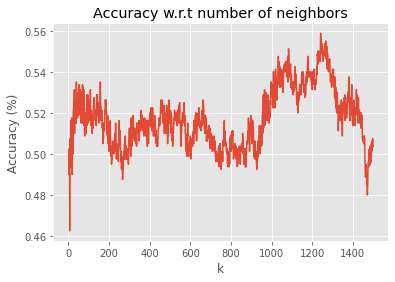

In [10]:
kNN = kNNfinder(DS2["Train"], DS2["Valid"])
Accu = TrainK(DS2["Valid"], kNN, range(1,nk))
(K,AccuM)=max(Accu, key=lambda x:x[1])
plotAccuracy(Accu)
printResult(Accu, nk)

kNN = kNNfinder(DS2["Train"], DS2["Test"])
Accu = TrainK(DS2["Test"], kNN, [K])
(K,AccuM)=max(Accu, key=lambda x:x[1])
print(f"Accuracy for Test Set is {AccuM*100:.2f}% w.r.t {K} Neighbors.")

In [17]:
for k in [1,2]:
    for i in ["Train", "Test", "Valid"]:
        for j in ["X", "Y"]:
            DS1[i][j]
            np.savetxt(f'DS{k}_{i}_{j}.csv', DS1[i][j], delimiter=',', fmt='%+.3f')